In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [2]:
# create ticker object and fetch historical market data
def ticker_history(comp, dt):
    ticker = yf.Ticker(comp)
    df = ticker.history(period=dt)
    return df

In [3]:
# standardize training data
def scale_fit_transform(train, scaler):
    train = train.reshape(-1, 1)
    trainStd = scaler.fit_transform(train)
    return trainStd

In [4]:
# create LSTM model
def model_lstm(step, feature, unit):
    lstm = Sequential()
    lstm.add(LSTM(units=100, activation='tanh', input_shape=(step, feature)))
    lstm.add(Dense(units=unit))
    lstm.compile(optimizer='adam', loss='mse')
    return lstm

In [5]:
# setup input and output for forecast
def set_forecast(df, back, forecast):
    X = []
    y = []
    for i in range(back, len(df) - forecast + 1):
        X.append(df[i - back: i])
        y.append(df[i: i + forecast])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [6]:
# forecast data from trained LSTM model
def forecast_lstm(df, model, scaler, back):
    X = df[- back:]
    X = X.reshape(1, back, 1)
    y = model.predict(X).reshape(-1, 1)
    y = scaler.inverse_transform(y)
    return X, y

In [7]:
# convert present and forecast data to dataframe
def forecast_df(df, col, y, model, scaler, step, forecast):
    past = df[[col]].reset_index()
    past.rename(columns={'index': 'Date', col: 'Real'}, inplace=True)
    past['Date'] = pd.to_datetime(past['Date'])
    future = pd.DataFrame(columns=['Date', 'Predict'])
    future['Date'] = pd.date_range(start=past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast)
    future['Predict'] = y.flatten()
    return past, future

In [8]:
comp = ['NVDA', 'AMD']
cols = ['Open', 'High', 'Low', 'Close']
col = cols[1]
dt = '5y'
tSplit = 2023
step = 100
forecast = 100
feature = 1
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
# create dataframe
dfNVDA = ticker_history(comp[0], dt)
dfAMD = ticker_history(comp[1], dt)

# column of interest
colNVDA = dfNVDA[col].values.reshape(-1, 1)
colAMD = dfAMD[col].values.reshape(-1, 1)

# scale the data
colNVDA = scale_fit_transform(colNVDA, scaler)
colAMD = scale_fit_transform(colAMD, scaler)

In [10]:
XNVDA, yNVDA = set_forecast(colNVDA, step, forecast)
XAMD, yAMD = set_forecast(colAMD, step, forecast)

lstmNVDA = model_lstm(step, feature, forecast)
lstmAMD = model_lstm(step, feature, forecast)

lstmNVDA.fit(XNVDA, yNVDA, epochs=10, batch_size=32)
lstmAMD.fit(XAMD, yAMD, epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0633
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0091
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0042
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0051
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0039
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0038
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0035
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0046
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0036
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0035
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1231
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0178
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0160
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0155
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0155
Epoch 6/10
34/34 ━

In [12]:
XPredNVDA, yPredNVDA = forecast_lstm(colNVDA, lstmNVDA, scaler, step)
XPredAMD, yPredAMD = forecast_lstm(colAMD, lstmAMD, scaler, step)

pastNVDA, futureNVDA = forecast_df(dfNVDA, col, yPredNVDA, lstmNVDA, scaler, step, forecast)
pastAMD, futureAMD = forecast_df(dfAMD, col, yPredAMD, lstmAMD, scaler, step, forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


In [13]:
def plot_forecast(past, future, name):
    df = pd.concat([past, future]).set_index('Date')
    df.plot(title=name)

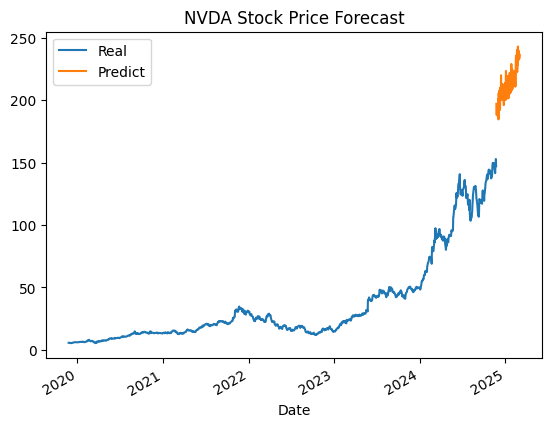

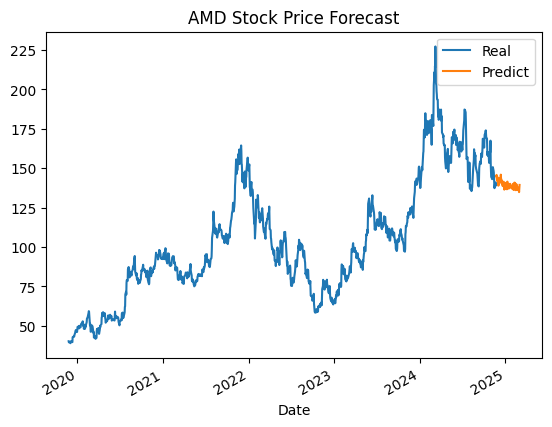

In [14]:
plot_forecast(pastNVDA, futureNVDA, 'NVDA Stock Price Forecast')
plot_forecast(pastAMD, futureAMD, 'AMD Stock Price Forecast')

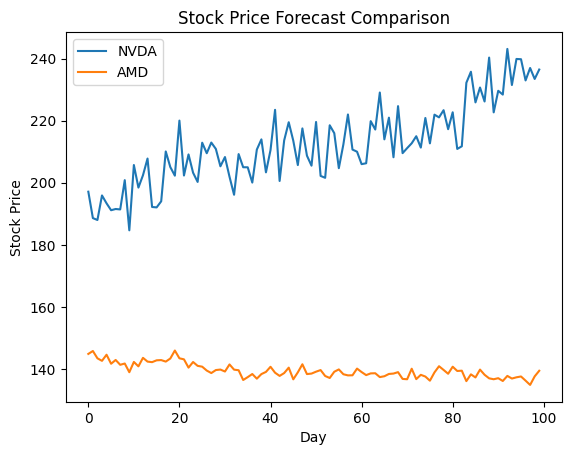

In [15]:
plt.plot(futureNVDA['Predict'], label='NVDA')
plt.plot(futureAMD['Predict'], label='AMD')
plt.title('Stock Price Forecast Comparison')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [16]:
# create dataframe containing future date and data forecast
dfForecast = pd.DataFrame({'Date': futureNVDA['Date'], 'NVDA': futureNVDA['Predict'], 'AMD': futureAMD['Predict']})
dfForecast.set_index('Date', inplace=True)
# output dataframe
# dfForecast.to_csv('nvda_amd_forecast.csv')